# Segmenting and Clustering Neighborhoods in Toronto
This project involves the process of segmenting and clustering neighborhoods in Toronto

## Part 1 - Webscraping 
Webscraping is performed on the data available from Wikipedia. To perform this task, all the dependencies are  initialized. The data is extracted from wikipedia page using BeautifulSoup. The postal codes are extracted from the csv file and combined with the dataframe.

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

In [2]:
#Scraping the data from wikipedia page
url = "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M"
data = requests.get(url).text
soup = BeautifulSoup(data,"html5lib")
tables = soup.find_all('table')[0]

In [3]:
#Converting the html table to dataframe
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
        
toronto_data=pd.DataFrame(table_contents)
toronto_data['Borough']=toronto_data['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

toronto_data.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [4]:
#Remove the boroughs with 'Not assigned' 
toronto_data = toronto_data[toronto_data['Borough']!="Not assigned"]
toronto_data = toronto_data.reset_index(drop=True)
toronto_data.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [5]:
print("\n The shape of the dataframe is",toronto_data.shape)


 The shape of the dataframe is (103, 3)


## Part 2 - Grouping the data with Postal code

In [6]:
# Grouping the data with respect to Postal Code 
df_postcode = toronto_data.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(', '.join).reset_index()
df_postcode.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [7]:
# import the data for longitude and latitude from csv file
data_lat = pd.read_csv('Final_Assignment_Library.csv',index_col = 'Postal Code')
data_lat.head()

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


In [8]:
# joining the two data to a single dataframe
toronto_df = df_postcode.join(data_lat, on='PostalCode') 
toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Part 3 - Explore and Cluster the neighborhoods in Toronto

In [9]:
# Importing the other dependencies 
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
import folium 
import geocoder
from geopy.geocoders import Nominatim

Find the geographical coordinate for Toronto

In [10]:

address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [11]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

In [12]:
# Extract the Boroughs that contain the word Toronto
toronto_new_data = toronto_df[toronto_df['Borough'].str.contains( 'Toronto')].reset_index(drop=True)
toronto_new_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106
2,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
3,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
4,M4M,East Toronto,Studio District,43.659526,-79.340923


In [13]:
# create map of Toronto using latitude and longitude values for boroughs with the word Toronto
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_new_data['Latitude'], toronto_new_data['Longitude'], toronto_new_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto


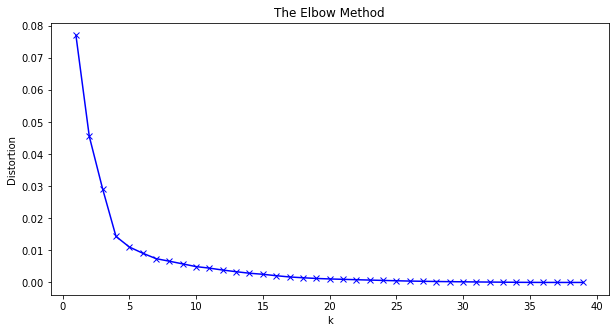

In [14]:
# Elbow method to find the number of clusters
distortions = []

toronto_neighborhood_clustering = toronto_new_data.drop(['PostalCode','Borough','Neighborhood'], 1)

K = range(1,40)
for k in K:
    kmean = KMeans(n_clusters=k, random_state=0, n_init = 50, max_iter = 500)
    kmean.fit(toronto_neighborhood_clustering)
    distortions.append(kmean.inertia_)

plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

From the elbow method, it can be seen that the number of clusters in which the boroughs can be divided is between 4 and 5. In this case, 5 is used.

In [15]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=3).fit(toronto_neighborhood_clustering)

# check cluster labels generated for each row in the dataframe
print("The kmeans cluster lables is ",kmeans.labels_[0:10])

toronto_df = toronto_new_data

# add clustering labels
toronto_df.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_df.head()

The kmeans cluster lables is  [3 3 3 3 3 1 1 1 1 1]


,Cluster Labels,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,3,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,3,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106
2,3,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
3,3,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
4,3,M4M,East Toronto,Studio District,43.659526,-79.340923


In [16]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_new_data['Latitude'], toronto_new_data['Longitude'], toronto_new_data['Neighborhood'], toronto_new_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Explore the nearby venues Neighborhoods in Toronto
Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [17]:
# @hidden_cell
CLIENT_ID = 'YQ50HOVXFDCZXLKAANYY5KE540E5R50JVRF41EU2I3AQCNPD' # your Foursquare ID
CLIENT_SECRET = '0XORRJYZIKRRVKFAO52BICVSQIHEASZ1HVFUBZDK4WJETV30' # your Foursquare Secret
ACCESS_TOKEN = 'FAWCLOIKRFFBNYLVHYUZBTTSCTCQX31KOZSIB4S35CJGL4E2' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhoods Latitude', 
                  'Neighborhoods Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
toronto_venues = getNearbyVenues(names = toronto_new_data['Neighborhood'],latitudes = toronto_new_data['Latitude'],longitudes = toronto_new_data['Longitude'] )

The Beaches
The Danforth  East
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Enclave of M5E
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High Park, The Junction 

In [20]:
print(toronto_venues.shape)
toronto_venues.head()

(833, 7)


,Neighborhood,Neighborhoods Latitude,Neighborhoods Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,The Danforth East,43.685347,-79.338106,Aldwych Park,43.684901,-79.341091,Park


In [21]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhoods Latitude,Neighborhoods Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,30,30,30,30,30,30
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,30,30,30,30,30,30
Christie,16,16,16,16,16,16
Church and Wellesley,30,30,30,30,30,30
"Commerce Court, Victoria Hotel",30,30,30,30,30,30
Davisville,30,30,30,30,30,30
Davisville North,10,10,10,10,10,10


In [22]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 189 uniques categories.


### Analyzing each neighborhood like the New York example

In [23]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

column_n = toronto_onehot.pop('Neighborhood')

toronto_onehot.insert(0, 'Neighborhood', column_n)
toronto_onehot.head()


,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Danforth East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Berczy Park,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.0,0.0,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0000,0.0000,0.0000,0.000,0.000,0.000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,"CN Tower, King and Spadina, Railway Lands, Har...",0.0625,0.0625,0.0625,0.125,0.125,0.125,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,Central Bay Street,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.033333
4,Christie,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [25]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    #print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Seafood Restaurant,Farmers Market,Cocktail Bar,Coffee Shop,Tailor Shop,Bakery,Café,Fountain,French Restaurant,Museum
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Grocery Store,Bakery,Pet Store,Performing Arts Venue,Restaurant,Climbing Gym,Nightclub
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Airport,Bar,Rental Car Location,Coffee Shop,Sculpture Garden,Boat or Ferry,Boutique
3,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Thai Restaurant,Bubble Tea Shop,Miscellaneous Shop,Modern European Restaurant,Spa,Sandwich Place,Chinese Restaurant
4,Christie,Grocery Store,Café,Park,Coffee Shop,Candy Store,Restaurant,Italian Restaurant,Athletics & Sports,Nightclub,Baby Store


### Clustering Neigborhoods
Run _k_-means to cluster the neighborhood into 5 clusters.

In [28]:
# set number of clusters
kclusters_1 = 5

toronto_new_data=toronto_new_data.drop(['Cluster Labels'],1)

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans_1 = KMeans(n_clusters=kclusters_1, random_state=3).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_1.labels_[0:10] 


array([4, 4, 4, 4, 4, 4, 4, 4, 2, 4], dtype=int32)

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans_1.labels_)

toronto_merged = toronto_new_data

# merge manhattan_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].fillna(0).astype(int)

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Health Food Store,Pub,Trail,Airport,Museum,Martial Arts School,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant
1,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106,1,Park,Convenience Store,Airport,Museum,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant
2,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,4,Greek Restaurant,Italian Restaurant,Restaurant,Bookstore,Ice Cream Shop,Bubble Tea Shop,Coffee Shop,Cosmetics Shop,Dessert Shop,Fruit & Vegetable Store
3,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,2,Pizza Place,Sandwich Place,Fast Food Restaurant,Sushi Restaurant,Park,Pub,Movie Theater,Restaurant,Brewery,Pet Store
4,M4M,East Toronto,Studio District,43.659526,-79.340923,4,Coffee Shop,Café,Bakery,American Restaurant,Yoga Studio,Park,Brewery,Seafood Restaurant,Cheese Shop,Coworking Space


In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining clusters
Each cluster is examined based on the defining categories

In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,East York/East Toronto,1,Park,Convenience Store,Airport,Museum,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant
11,Downtown Toronto,1,Park,Playground,Trail,Movie Theater,Market,Martial Arts School,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant


In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,2,Health Food Store,Pub,Trail,Airport,Museum,Martial Arts School,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant
3,East Toronto,2,Pizza Place,Sandwich Place,Fast Food Restaurant,Sushi Restaurant,Park,Pub,Movie Theater,Restaurant,Brewery,Pet Store
6,Central Toronto,2,Gym / Fitness Center,Sandwich Place,Gym,Breakfast Spot,Convenience Store,Hotel,Park,Food & Drink Shop,Dance Studio,Department Store
24,Central Toronto,2,Park,Trail,Jewelry Store,Sushi Restaurant,Airport,Monument / Landmark,Martial Arts School,Men's Store,Metro Station,Mexican Restaurant
38,East Toronto Business,2,Light Rail Station,Yoga Studio,Auto Workshop,Brewery,Farmers Market,Fast Food Restaurant,Pizza Place,Skate Park,Restaurant,Burrito Place


In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Central Toronto,3,Pool,Home Service,Garden,Airport,Museum,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop


In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,East Toronto,4,Greek Restaurant,Italian Restaurant,Restaurant,Bookstore,Ice Cream Shop,Bubble Tea Shop,Coffee Shop,Cosmetics Shop,Dessert Shop,Fruit & Vegetable Store
4,East Toronto,4,Coffee Shop,Café,Bakery,American Restaurant,Yoga Studio,Park,Brewery,Seafood Restaurant,Cheese Shop,Coworking Space
7,Central Toronto,4,Clothing Store,Coffee Shop,Yoga Studio,Fast Food Restaurant,Spa,Sporting Goods Shop,Café,Salon / Barbershop,Restaurant,Chinese Restaurant
8,Central Toronto,4,Dessert Shop,Italian Restaurant,Café,Pizza Place,Gym,Sandwich Place,Coffee Shop,Sushi Restaurant,Brewery,Restaurant
10,Central Toronto,4,Coffee Shop,Bank,Bagel Shop,Fried Chicken Joint,Sushi Restaurant,Restaurant,Supermarket,Light Rail Station,Pub,American Restaurant
12,Downtown Toronto,4,Bakery,Coffee Shop,Restaurant,Italian Restaurant,Café,Pub,Pet Store,Deli / Bodega,Park,Diner
13,Downtown Toronto,4,Ramen Restaurant,Beer Bar,Bookstore,Men's Store,Breakfast Spot,Dance Studio,Bubble Tea Shop,Burger Joint,Burrito Place,Mexican Restaurant
14,Downtown Toronto,4,Coffee Shop,Park,Breakfast Spot,Café,Bakery,Mexican Restaurant,Farmers Market,Distribution Center,Dessert Shop,Spa
15,Downtown Toronto,4,Café,Clothing Store,Theater,Ramen Restaurant,College Rec Center,Burger Joint,Burrito Place,Shopping Mall,Sandwich Place,Coffee Shop
16,Downtown Toronto,4,Coffee Shop,Farmers Market,Café,Gastropub,Hotel,Thai Restaurant,Cosmetics Shop,Diner,Park,New American Restaurant


In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Central Toronto,0,Park,Swim School,Bus Line,Airport,Movie Theater,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop
9,Central Toronto,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## The maps may not be visible in github. Please find the attached link in r